In [1]:
%load_ext autoreload 
%autoreload 2 

In [34]:
import random
import os
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec # for subplots
import pandas as pd
import numpy as np
import seaborn as sns
import seaborn.objects as so
import tensorflow as tf
import json
tf.get_logger().setLevel('WARNING')

from src.data_processing.pipelines.LSTMPipe import LSTMPipe
from src.models.experimental_dropout_StackedLSTM import StackedLSTM

In [3]:
# print gpus available
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  2


In [38]:
DATA_PATH = '/projects/p31961/gaby_data/aggregated_data/raw_data/datasets/raw_data_raw_data.parquet.gzip'
MODEL_PATH = "/projects/p31961/ENIGMA/results/experiments/full_sequence_stacked_lstm_01/models/full_sequence_stacked_lstm_01"

# local
# DATA_PATH = '/Users/mds8301/iterm_data_storage/raw_data_raw_data.parquet.gzip'
# MODEL_PATH = '/Users/mds8301/Development/enigma/results/experiments/full_sequence_stacked_lstm_01/models/full_sequence_stacked_lstm_01'

In [40]:
with open('/projects/p31961/ENIGMA/results/experiments/full_sequence_stacked_lstm_01/subjects.json', 'r') as f:
    subjects = json.load(f)
subjects

{'training': [2, 6, 8, 1, 4, 10, 7, 13, 3], 'dev': [11, 0], 'test': [5, 9, 12]}

In [41]:
processor = LSTMPipe(DATA_PATH)
processor.read_raw_data(dropna=True)

training_subjects = subjects['training']
dev_subjects = subjects['dev']
test_subjects = subjects['test']

training_query = ' or '.join([f"mouse_id=={subject}" for subject in training_subjects])
dev_query = ' or '.join([f"mouse_id=={subject}" for subject in dev_subjects])
test_query = ' or '.join([f"mouse_id=={subject}" for subject in test_subjects])

def split_by_subjects_query(subjects):
    query = ' or '.join([f"mouse_id=={subject}" for subject in subjects])
    x, y = processor.raw_data.query(query).drop(columns ="signal"), processor.raw_data.query(query)['signal']
    return x, y

processor.X_train, processor.y_train = split_by_subjects_query(training_subjects)
processor.X_dev, processor.y_dev = split_by_subjects_query(dev_subjects)
processor.X_test, processor.y_test = split_by_subjects_query(test_subjects)
processor.transorm_data()

In [42]:
model = tf.keras.models.load_model(MODEL_PATH, compile= True)

2023-08-30 14:05:15.896882: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients_split_2_grad_concat_split_2_split_dim' with dtype int32
	 [[{{node gradients_split_2_grad_concat_split_2_split_dim}}]]
2023-08-30 14:05:15.896999: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients_split_grad_concat_split_split_dim' with dtype int32
	 [[{{node gradients_split_grad_concat_split_split_dim}}]]
2023-08-30 14:05:15.897073: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [43]:
model.summary()

Model: "stacked_lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Lambda_1 (Lambda)           multiple                  0         
                                                                 
 LSTM_1 (LSTM)               multiple                  5472      
                                                                 
 Dropout_1 (Dropout)         multiple                  0         
                                                                 
 LSTM_2 (LSTM)               multiple                  10512     
                                                                 
 Dropout_2 (Dropout)         multiple                  0         
                                                                 
 Dense_output (Dense)        multiple                  37        
                                                                 
Total params: 16,021
Trainable params: 16,021
Non-trai

In [44]:
prediction = model.predict(processor.X_test)

2023-08-30 14:05:30.644485: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,18]
	 [[{{node inputs}}]]
2023-08-30 14:05:38.268600: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
Could not load symbol cublasGetSmCountTarget from libcublas.so.11. Error: /home/mds8301/.conda/envs/enigma/lib/libcublas.so.11: undefined symbol: cublasGetSmCountTarget


37528/37528 [==============================] - 71s 2ms/step


In [127]:
def build_test_data_from_processor(processor):
    categories = processor.processor.named_transformers_.cat.get_feature_names_out().tolist()
    def get_feature_labels(processor):
        cols_ = []
        for key in processor.named_transformers_.keys():
            cols = processor.named_transformers_[key].get_feature_names_out().tolist()
            cols_+=cols
        return cols_
    
    def undo_hot_encoding_by_name(key_word: str, columns: list, df_: pd.DataFrame):
        values = df_[[c for c in columns if key_word in c]].idxmax(axis=1,).str.replace(key_word, "")
        return values
    return (
        pd.DataFrame(processor.X_test,
                     columns=get_feature_labels(processor.processor))
        .assign(true_signal=processor.y_test.reset_index(drop=True), 
                predicted_signal = prediction, 
                sensor = lambda df_: undo_hot_encoding_by_name("sensor_", categories, df_),
                events = lambda df_: undo_hot_encoding_by_name("event_", categories, df_),
                sex = lambda df_: undo_hot_encoding_by_name("sex_", categories, df_),
                )
        .drop(columns = categories)
                
    )
test_data = build_test_data_from_processor(processor)
test_data   

,mouse_id,day,time,trial,latency,learning_phase,trial_count,true_signal,predicted_signal,sensor,events,sex
0,1.598022,0.567204,-1.728238,-1.389145,-0.563085,-0.868343,0.437602,-0.155359,-0.016698,D2,cue,F
1,1.598022,0.567204,-1.720674,-1.389145,-0.563085,-0.868343,0.437602,-0.420553,-0.016763,D2,cue,F
2,1.598022,0.567204,-1.713110,-1.389145,-0.563085,-0.868343,0.437602,-1.592294,-0.016884,D2,cue,F
3,1.598022,0.567204,-1.705546,-1.389145,-0.563085,-0.868343,0.437602,-1.268734,-0.016942,D2,cue,F
4,1.598022,0.567204,-1.697982,-1.389145,-0.563085,-0.868343,0.437602,-0.210176,-0.017041,D2,cue,F
...,...,...,...,...,...,...,...,...,...,...,...,...
1200886,-0.257635,0.082372,1.698257,-0.008171,2.353921,0.478740,0.143124,-0.010664,0.346891,DA,escape,M
1200887,-0.257635,0.082372,1.705821,-0.008171,2.353921,0.478740,0.143124,0.472312,0.347652,DA,escape,M
1200888,-0.257635,0.082372,1.713385,-0.008171,2.353921,0.478740,0.143124,0.005370,0.347909,DA,escape,M
1200889,-0.257635,0.082372,1.720949,-0.008171,2.353921,0.478740,0.143124,-0.525126,0.347935,DA,escape,M


## predicted vs true signal for test set

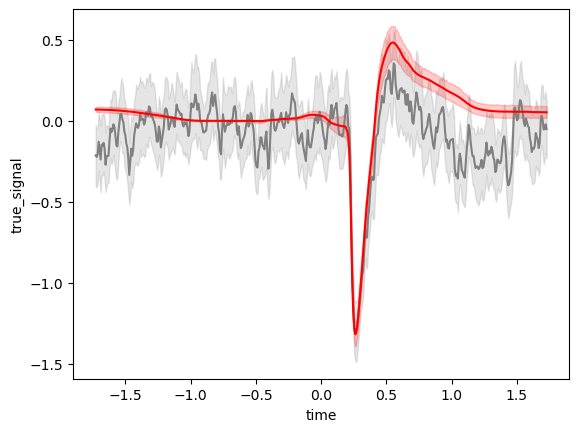

In [129]:
def plot_da_final_day(df):
    max_day = df['day'].max()
    query = "day==@max_day & sensor=='DA' & events=='cue'"
    da_cue = df.query(query)
    sns.lineplot(data = da_cue, x = 'time', y = 'true_signal', color = 'grey')
    sns.lineplot(data = da_cue, x = 'time', y = 'predicted_signal', color = 'red')
plot_da_final_day(test_data)

## predicted vs true signal for dev set

In [118]:
def build_dev_data_from_processor(processor):
    categories = processor.processor.named_transformers_.cat.get_feature_names_out().tolist()
    def get_feature_labels(processor):
        cols_ = []
        for key in processor.named_transformers_.keys():
            cols = processor.named_transformers_[key].get_feature_names_out().tolist()
            cols_+=cols
        return cols_
    
    def undo_hot_encoding_by_name(key_word: str, columns: list, df_: pd.DataFrame):
        values = df_[[c for c in columns if key_word in c]].idxmax(axis=1,).str.replace(key_word, "")
        return values
    return (
        pd.DataFrame(processor.X_dev,
                     columns=get_feature_labels(processor.processor))
        .assign(true_signal=processor.y_dev.reset_index(drop=True), 
                predicted_signal = model.predict(processor.X_dev), 
                sensor = lambda df_: undo_hot_encoding_by_name("sensor_", categories, df_),
                events = lambda df_: undo_hot_encoding_by_name("event_", categories, df_),
                sex = lambda df_: undo_hot_encoding_by_name("sex_", categories, df_),
                )
        .drop(columns = categories)
                
    )
dev_data = build_dev_data_from_processor(processor)
dev_data

29549/29549 [==============================] - 49s 2ms/step


,mouse_id,day,time,trial,latency,learning_phase,trial_count,true_signal,predicted_signal,sensor,events,sex
0,-1.583104,0.567204,-1.728238,-1.389145,-0.563085,-0.868343,0.454924,0.363273,-0.095338,DA,avoid,F
1,-1.583104,0.567204,-1.720674,-1.389145,-0.563085,-0.868343,0.454924,1.595457,-0.094562,DA,avoid,F
2,-1.583104,0.567204,-1.713110,-1.389145,-0.563085,-0.868343,0.454924,0.530688,-0.094163,DA,avoid,F
3,-1.583104,0.567204,-1.705546,-1.389145,-0.563085,-0.868343,0.454924,0.442796,-0.093444,DA,avoid,F
4,-1.583104,0.567204,-1.697982,-1.389145,-0.563085,-0.868343,0.454924,-0.595978,-0.092799,DA,avoid,F
...,...,...,...,...,...,...,...,...,...,...,...,...
945559,-1.583104,0.082372,1.698257,-0.008171,-0.563085,0.478740,0.143124,-0.102628,-0.081311,DA,shock,F
945560,-1.583104,0.082372,1.705821,-0.008171,-0.563085,0.478740,0.143124,0.142057,-0.079871,DA,shock,F
945561,-1.583104,0.082372,1.713385,-0.008171,-0.563085,0.478740,0.143124,0.337562,-0.079029,DA,shock,F
945562,-1.583104,0.082372,1.720949,-0.008171,-0.563085,0.478740,0.143124,0.328688,-0.078226,DA,shock,F


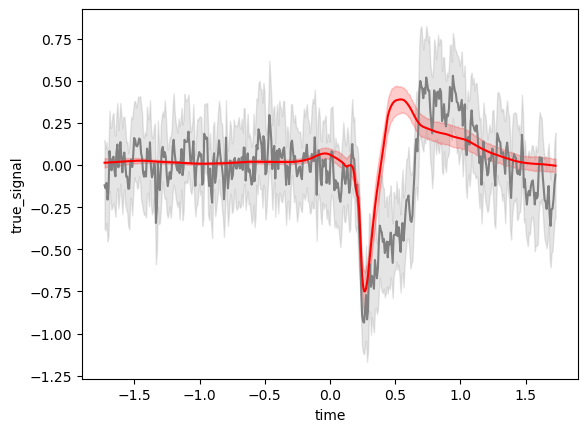

In [130]:
plot_da_final_day(dev_data)

## predicted vs true signal for training set

In [ ]:
def build_train_data_from_processor(processor):
    categories = processor.processor.named_transformers_.cat.get_feature_names_out().tolist()
    def get_feature_labels(processor):
        cols_ = []
        for key in processor.named_transformers_.keys():
            cols = processor.named_transformers_[key].get_feature_names_out().tolist()
            cols_+=cols
        return cols_
    
    def undo_hot_encoding_by_name(key_word: str, columns: list, df_: pd.DataFrame):
        values = df_[[c for c in columns if key_word in c]].idxmax(axis=1,).str.replace(key_word, "")
        return values
    return (
        pd.DataFrame(processor.X_train,
                     columns=get_feature_labels(processor.processor))
        .assign(true_signal=processor.y_train.reset_index(drop=True), 
                predicted_signal = model.predict(processor.X_train), 
                sensor = lambda df_: undo_hot_encoding_by_name("sensor_", categories, df_),
                events = lambda df_: undo_hot_encoding_by_name("event_", categories, df_),
                sex = lambda df_: undo_hot_encoding_by_name("sex_", categories, df_),
                )
        .drop(columns = categories)
                
    )
train_data = build_dev_data_from_processor(processor)
train_data

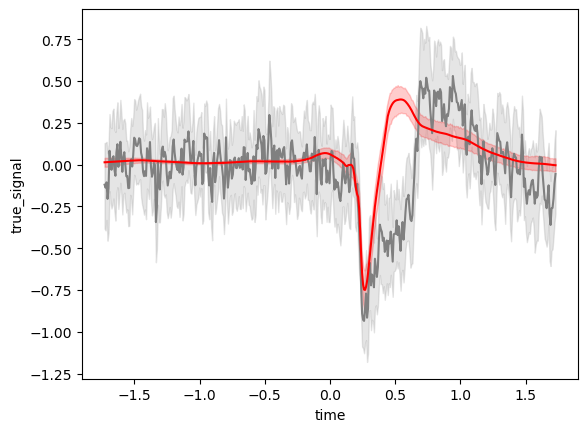

In [132]:
plot_da_final_day(train_data)

# predicted signal from train, dev and test set

<Axes: xlabel='time', ylabel='predicted_signal'>

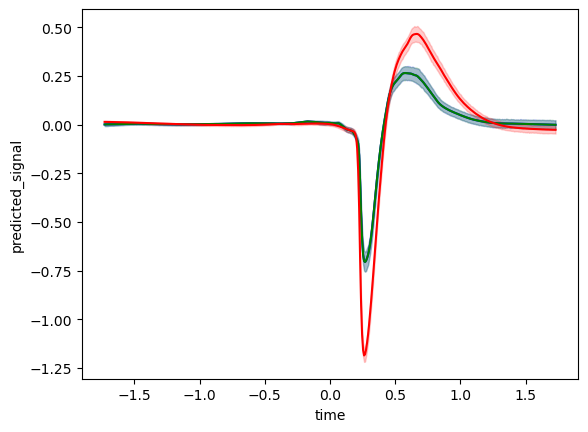

In [142]:
train_da_cue = train_data.query("sensor == 'DA' & events == 'cue'")
dev_da_cue = dev_data.query("sensor == 'DA' & events == 'cue'")
test_da_cue = test_data.query("sensor == 'DA' & events == 'cue'")

sns.lineplot(data = train_da_cue, x = 'time', y = 'predicted_signal', color = 'blue')
sns.lineplot(data = dev_da_cue, x = 'time', y = 'predicted_signal', color = 'green')
sns.lineplot(data = test_da_cue, x = 'time', y = 'predicted_signal', color = 'red')

# Summary
According to the training data, the model is still overfitting. However it seems to predict somewhat consistently between training, dev and test sets. I need to see how to improve training and validation error. 

-> validation error is going UP  with training